In [3]:
# on importe les differentes librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
avis = pd.read_csv("BDD/avis_sans_outliers.csv")

In [5]:
avis.describe()

,Unnamed: 0,note
count,117680.000000,117680.000000
mean,87982.722757,7.587483
std,49945.027707,1.792083
min,0.000000,4.000000
25%,45757.750000,6.000000
50%,86306.500000,8.000000
75%,130656.250000,9.000000
max,176210.000000,10.000000


In [6]:
num_users = avis['author'].nunique()
num_items = avis['title'].nunique()

print(f"Il y a {num_users} auteurs et {num_items} jeux")

# Calcul de la sparsité
sparsity = (len(avis) / (num_users * num_items)) * 100
print(f"Notre matrice a une sparsité de {sparsity:.2f}% ")

Il y a 2458 auteurs et 2911 jeux
Notre matrice a une sparsité de 1.64% 


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Pivot the data to create a user-item rating matrix
user_item_matrix = avis.pivot_table(index='author', columns='title', values='note')

# Replace NaN values with 0, as we'll compute cosine similarity (NaN would cause issues)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Compute the cosine similarity among users
cosine_sim = cosine_similarity(user_item_matrix_filled)

# Convert the cosine similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)

cosine_sim_df.head()


author,*FitzChevalerie*,--- JD ---,-Yo-,20.100,20cil,26vince,3dman,6*M*A*S*H,666Raziel,6gale,...,zharg le borgne,zico,zinv,ziwzaw,zombywoof,zorghk,zorglub,zorl,§Gama§,égécriéaline
author,,,,,,,,,,,,,,,,,,,,,
*FitzChevalerie*,1.000000,0.037856,0.000000,0.000000,0.049021,0.041580,0.0,0.000000,0.104409,0.107581,...,0.000000,0.000000,0.000000,0.106050,0.061598,0.000000,0.000000,0.000000,0.000000,0.00000
--- JD ---,0.037856,1.000000,0.054096,0.050875,0.043560,0.018998,0.0,0.024928,0.155072,0.127184,...,0.000000,0.066620,0.067546,0.046997,0.213677,0.032501,0.024209,0.020097,0.019142,0.03436
-Yo-,0.000000,0.054096,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.048886,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.083188,0.097590,0.000000,0.000000,0.000000,0.00000
20.100,0.000000,0.050875,0.000000,1.000000,0.015977,0.042350,0.0,0.000000,0.028961,0.000000,...,0.062687,0.050003,0.040052,0.017282,0.000000,0.000000,0.025332,0.096100,0.000000,0.00000
20cil,0.049021,0.043560,0.000000,0.015977,1.000000,0.000000,0.0,0.000000,0.000000,0.012994,...,0.000000,0.000000,0.044899,0.048434,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


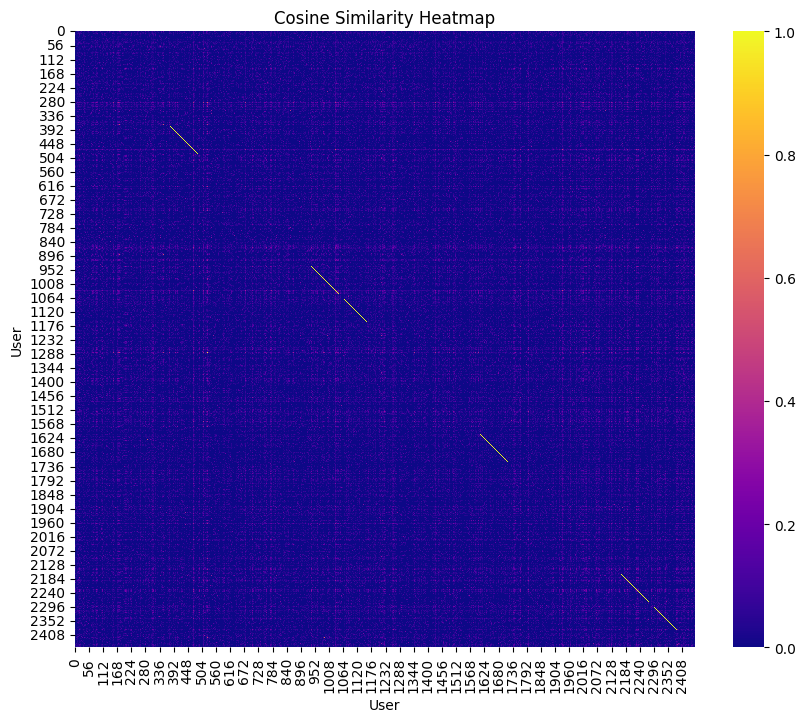

In [17]:
# Set the size of the plot
plt.figure(figsize=(10, 8))

# Plot the heatmap of cosine similarity
sns.heatmap(cosine_sim, cmap='plasma')

# Adding title and labels for clarity
plt.title('Cosine Similarity Heatmap')
plt.xlabel('User')
plt.ylabel('User')

# Show the plot
plt.show()


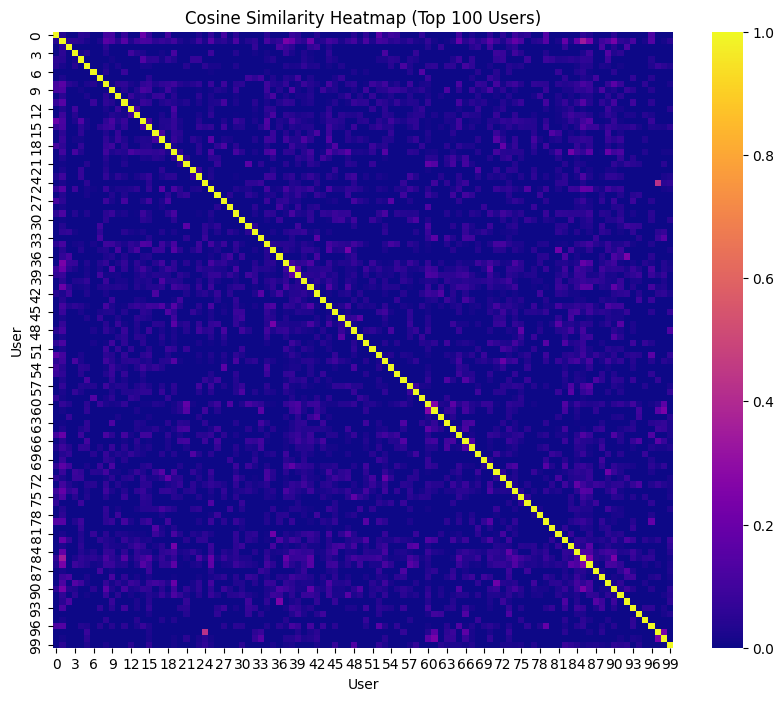

In [18]:
# Set the size of the plot
plt.figure(figsize=(10, 8))

# Plot the heatmap of cosine similarity
sns.heatmap(cosine_sim[:100, :100], cmap='plasma')

# Adding title and labels for clarity
plt.title('Cosine Similarity Heatmap (Top 100 Users)')
plt.xlabel('User')
plt.ylabel('User')

# Show the plot
plt.show()


In [31]:
from surprise import KNNBasic

# Configure the algorithm to compute similarities between items
sim_options = {
    'name': 'cosine',
    'user_based': False  # Compute similarities between items
}

algo = KNNBasic(k=10,sim_options=sim_options)


In [32]:
from surprise import accuracy
# Function to calculate MAE for a specific range of ratings
def calculate_mae_for_rating_range(predictions, lower_bound, upper_bound):
    # Filtering predictions within the specified rating range
    filtered_predictions = [pred for pred in predictions if lower_bound <= pred.r_ui <= upper_bound]
    
    # Calculating MAE for the filtered predictions
    if filtered_predictions:
        mae = accuracy.mae(filtered_predictions, verbose=False)
        return mae
    else:
        return None

In [33]:
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import mae
from collections import defaultdict

# Assuming you've already loaded your data into a 'data' variable

# Example dataset loading, replace with your actual data loading code
reader = Reader(line_format='user item rating', rating_scale=(0, 10))
data = Dataset.load_from_df(avis[['author', 'title', 'note']], reader)

# Splitting the dataset into train and test set for evaluation
trainset, testset = train_test_split(data, test_size=0.25)

# Train the algorithm on the trainset and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Calculate and print MAE for each rating range using the calculate_mae_for_rating_range function
rating_ranges = [(4, 5),(5, 6), (6, 7),(7, 8),(8, 9), (9, 10)]
mae_per_range = defaultdict(float)
for lower_bound, upper_bound in rating_ranges:
    mae = calculate_mae_for_rating_range(predictions, lower_bound, upper_bound)
    if mae is not None:
        mae_per_range[f'{lower_bound}-{upper_bound}'] = mae
        print(f'MAE for ratings between {lower_bound} and {upper_bound}: {mae}')
    else:
        print(f'No predictions found for ratings between {lower_bound} and {upper_bound}')


Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE for ratings between 4 and 5: 2.7554239924693458
MAE for ratings between 5 and 6: 1.3894316152535993
MAE for ratings between 6 and 7: 1.13074038111612
MAE for ratings between 7 and 8: 0.7498618724448413
MAE for ratings between 8 and 9: 0.8280926871239443
MAE for ratings between 9 and 10: 1.8416962274893012
